In [51]:
import numpy as np
from matplotlib import pyplot as plt

import os
import pickle
from time import time
from sklearn.decomposition import PCA

import george
from george import kernels
from scipy.optimize import minimize

from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

import lhsmdu
import os
import pdspy.modeling as modeling

%matplotlib inline

In [52]:
# get all model data
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    cube = np.array(pickle.load(fp))[:,100:500]
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    nancube = np.array(pickle.load(fp))[:,100:500]
    
# x values (wavelengths) - 500 values, in normal space
with open ('../grid_metadata/xvals.txt', 'rb') as fp:
    xvals = pickle.load(fp)[100:500]

# fix -infs: powerlaw cutoff
for i in range(len(cube)):
    if -np.inf in cube[i]:
        a = cube[i].tolist()
        a.reverse()
        ind = len(a)-a.index(-np.inf)
        x1 = xvals[ind]
        y1 = cube[i][ind]
        for j in range(ind):
            cube[i][j]=(100*(np.log10(xvals[j]/x1)))+y1
            
# nan cutoff for means            
nancube[nancube<-20]=np.nan

# subtracting from the seds each sample mean
seds_msub = cube - np.nanmean(nancube,axis=1)[:,np.newaxis]

t0 = time()
pca = PCA(n_components=40).fit(seds_msub)
print("done in %0.3fs" % (time() - t0))

eigenseds=np.array(pca.components_)

done in 0.144s


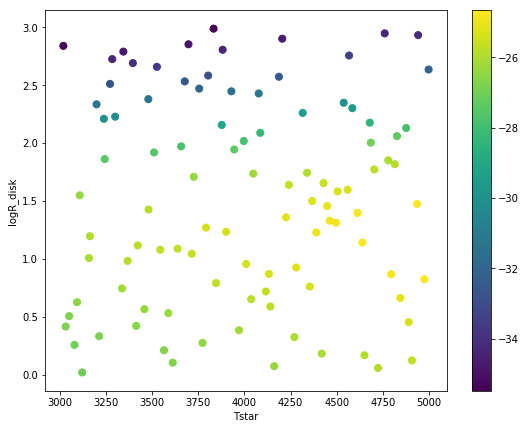

In [64]:
#directory="../grid/2dgrid/"
#coords=[[],[]]
#seds=[]
#for i in range(len(os.listdir(directory))):
#    coords[0].append(float(os.listdir(directory)[i].split("_")[(2*0)+1]))
#    coords[1].append(float(os.listdir(directory)[i].split("_")[(2*3)+1]))
#    filename=os.listdir(directory)[i]
#    model=modeling.YSOModel()
#    model.read_yso(directory+filename)
#    seds.append(np.log10(model.spectra["SED"].flux))
    
#with open('../grid_metadata/2dgrid_coords.txt', 'wb') as fp:
#    pickle.dump(coords, fp)
with open ('../grid_metadata/2dgrid_coords.txt', 'rb') as fp:
    coords = pickle.load(fp)
#with open('../grid_metadata/2dgrid_seds.txt', 'wb') as fp:
#    pickle.dump(seds, fp)
with open ('../grid_metadata/2dgrid_seds.txt', 'rb') as fp:
    slicevals = np.array(pickle.load(fp))[:,100:500]
with open ('../grid_metadata/2dgrid_seds.txt', 'rb') as fp:
    nanslicevals = np.array(pickle.load(fp))[:,100:500]
    
# fix -infs: powerlaw cutoff
for i in range(len(slicevals)):
    if -np.inf in slicevals[i]:
        a = slicevals[i].tolist()
        a.reverse()
        ind = len(a)-a.index(-np.inf)
        x1 = xvals[ind]
        y1 = slicevals[i][ind]
        for j in range(ind):
            slicevals[i][j]=(100*(np.log10(xvals[j]/x1)))+y1
                
nanslicevals[nanslicevals<-20]=np.nan

# subtracting from the seds each sample mean
slice_seds_msub = slicevals - np.nanmean(nanslicevals,axis=1)[:,np.newaxis]

fitdata=[]
for i in range(len(slicevals)):
    data=[coords[0][i],coords[1][i]]
    coeffs=pca.transform(slice_seds_msub[i].reshape(1,-1))
    for j in range(15):
        data.append(coeffs[0][j])
    fitdata.append(data)
fitdata=np.array(fitdata)

plt.figure(figsize=(9,7))
Tstar=fitdata[:,0]
logR_disk=fitdata[:,1]
w0=fitdata[:,2+0]
style = dict(cmap='viridis', vmin=np.min(w0), vmax=np.max(w0))
plt.scatter(Tstar,logR_disk, c=w0, s=50, **style)
plt.ylabel("logR_disk")
plt.xlabel("Tstar")
plt.colorbar()
plt.show()

In [141]:
sample=[]
for i in (0,1,2,3,4,5,6,7,8,9,9.9):
    sample.append(np.array([0,10,20,30,40,50,60,70,80,90,99])+[1000*i])
sample=np.array(sample).flatten()
sample=np.ndarray.tolist(sample)
sample=list(map(int,sample))

Initial ln-likelihood: -106.58
[ 1.6245934  18.42068074 -0.4462871 ]
[    2.25307669 10000.             0.8       ]


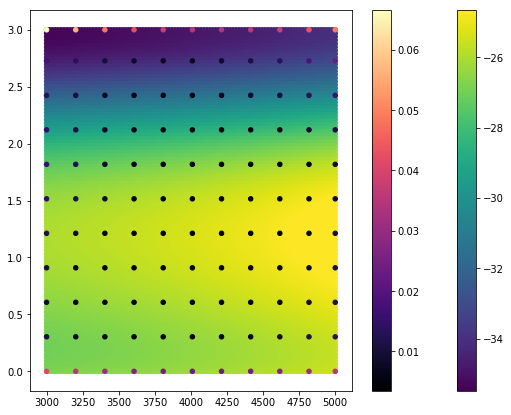

In [143]:
x=np.transpose(coords)
yerr=0.01*w0
kernel = np.var(w0) * kernels.ExpSquaredKernel(10000**2,ndim=2,axes=0)* kernels.ExpSquaredKernel(0.8**2,ndim=2,axes=1)
gp = george.GP(kernel)
gp.compute(x,yerr)

np.set_printoptions(suppress=True)
print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(w0)))
print(gp.get_parameter_vector())
print(np.sqrt(np.exp(gp.get_parameter_vector())))

x0pred,x1pred=np.meshgrid(np.linspace(3000, 5000, 100),np.linspace(0, 3, 100))
x_pred=list(map(lambda x, y:(x,y), np.ndarray.flatten(x0pred), np.ndarray.flatten(x1pred)))
pred, pred_var = gp.predict(w0, x_pred, return_var=True)

plt.figure(figsize=(9,7))
style = dict(cmap='viridis', vmin=np.min(w0), vmax=np.max(w0))
plt.scatter(np.array(x_pred)[:,0], np.array(x_pred)[:,1], c=pred, s=20, **style)
plt.colorbar()
plt.scatter(x[:, 0], x[:, 1], c=w0, s=50, **style,edgecolors='r')

style = dict(cmap='magma', vmin=np.min(pred_var), vmax=np.max(pred_var))
#plt.scatter(np.array(x_pred)[sample,0], np.array(x_pred)[sample,1], c=pred_var[sample], s=20, **style)
#plt.colorbar()

plt.show()

      fun: -2.3514059496758932
 hess_inv: array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])
      jac: array([-0.00000061,  0.00000025,  0.00000004])
  message: 'Optimization terminated successfully.'
     nfev: 1
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([ 5.64704105, 21.0993019 ,  0.97457088])

Final ln-likelihood: 2.35
[   16.83601806 38164.11484542     1.62789121]


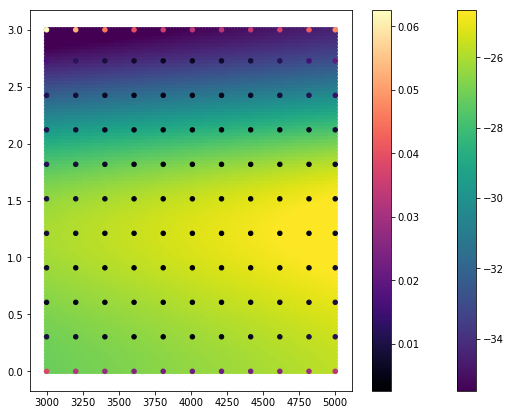

In [170]:
def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(w0)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(w0)

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(w0)))

print(np.sqrt(np.exp(gp.get_parameter_vector())))

pred, pred_var = gp.predict(w0, x_pred, return_var=True)

plt.figure(figsize=(9,7))
style = dict(cmap='viridis', vmin=np.min(w0), vmax=np.max(w0))
plt.scatter(np.array(x_pred)[:,0], np.array(x_pred)[:,1], c=pred, s=20, **style)
plt.colorbar()
#plt.scatter(x[:, 0], x[:, 1], c=w0, s=50, **style,edgecolors='r')

style = dict(cmap='magma', vmin=np.min(pred_var), vmax=np.max(pred_var))
plt.scatter(np.array(x_pred)[sample,0], np.array(x_pred)[sample,1], c=pred_var[sample], s=20, **style)
plt.colorbar()


plt.show()

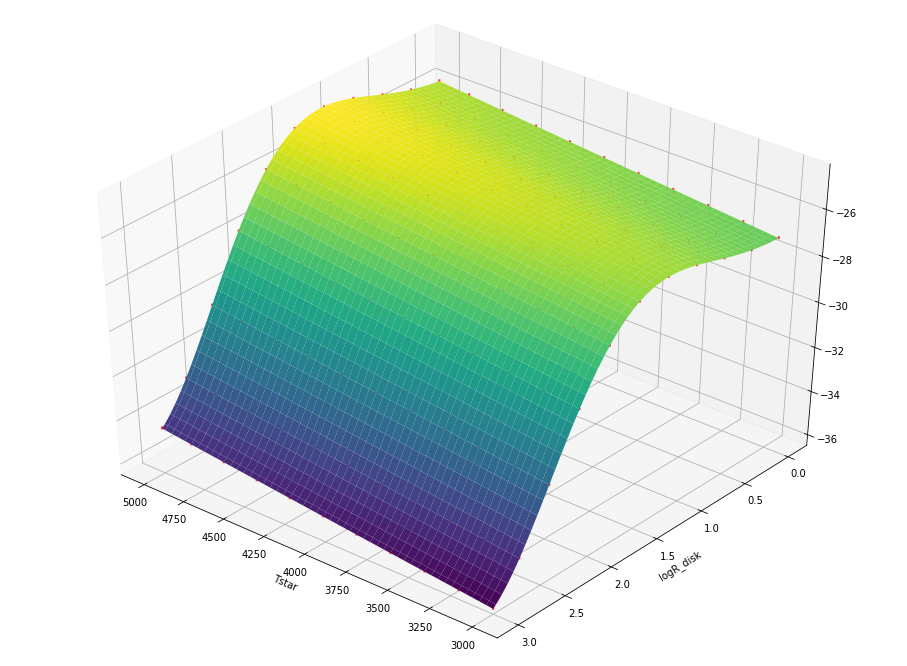

In [171]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111,projection='3d')

# Plot the surface.

surf = ax.plot_surface(x0pred,x1pred,pred.reshape(100,100),cmap=cm.viridis)

for i in range(len(sample)):
    x=[np.array(x_pred)[:,0][sample[i]],np.array(x_pred)[:,0][sample[i]]]
    y=[np.array(x_pred)[:,1][sample[i]],np.array(x_pred)[:,1][sample[i]]]
    z=[pred[sample[i]],pred[sample[i]]+pred_var[sample[i]]]
    ax.plot(x,y,z,'r',alpha=0.8,linewidth=2)
    
ax.set_ylabel("logR_disk")
ax.set_xlabel("Tstar")
ax.view_init(40, 130)
plt.show()
